In [2]:
import numpy as np
from joblib import load
# Loading the saved models
audio_model = load('C:/Users/chethan/Downloads/RIC/audio_model_saved.joblib') 
text_model = load('C:/Users/chethan/Downloads/RIC/logistic_regression_model.joblib')  
image_model = load('C:/Users/chethan/Downloads/RIC/efficientnet_model.joblib')  

In [3]:
import os
import librosa
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Function to load RAVDESS dataset
def load_ravdess_dataset(dataset_path):
    data = {'path': [], 'emotion': []}

    # Iterate over actor folders
    for actor_folder in os.listdir(dataset_path):
        actor_path = os.path.join(dataset_path, actor_folder)

        if os.path.isdir(actor_path):
            # Iterate over audio files in each actor folder
            for audio_file in os.listdir(actor_path):
                audio_path = os.path.join(actor_path, audio_file)

                # Extract emotion from the file name (assuming file names are structured)
                emotion = int(audio_file.split('-')[2])

                # Append data to the dictionary
                data['path'].append(audio_path)
                data['emotion'].append(emotion)

    # Creating a DataFrame from the dictionary
    df = pd.DataFrame(data)
    
    return df


dataset_path = r'C:\\Users\\chethan\\Downloads\\RIC\\audio_speech_actors_01-24'

# Load the dataset
ravdess_dataset = load_ravdess_dataset(dataset_path)


In [4]:
# Map emotion labels to stress levels
stress_mapping = {
    1: 'low_stress',
    2: 'low_stress',
    3: 'low_stress',
    4: 'low_stress',
    5: 'high_stress',
    6: 'high_stress',
    7: 'high_stress',
    8: 'high_stress',
}

ravdess_dataset['stress_level'] = ravdess_dataset['emotion'].map(stress_mapping)

In [5]:
# Displaying the loaded dataset
print(ravdess_dataset.head())

                                                path  emotion stress_level
0  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        1   low_stress
1  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        1   low_stress
2  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        1   low_stress
3  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        1   low_stress
4  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        2   low_stress


In [6]:
# Function to extract features from audio files
def extract_features(file_path):
    try:
        # Load audio file with librosa
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')

        # Extract features using librosa
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13), axis=1)
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate), axis=1)
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate), axis=1)
        contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate), axis=1)
        tonnetz = np.mean(librosa.feature.tonnetz(y=audio, sr=sample_rate), axis=1)

        # Combining all features into a single array
        feature_array = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))

    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}. Error: {e}")
        return None

    return feature_array

In [7]:
ravdess_dataset['features'] = ravdess_dataset['path'].apply(extract_features)


C:\Users\chethan\anaconda3\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=1012
  warnings.warn(


In [8]:
# Drop rows with missing features
ravdess_dataset = ravdess_dataset.dropna()

In [9]:
# Convert features to a list and labels to a NumPy array
X = np.array(ravdess_dataset['features'].tolist())
y = np.array(ravdess_dataset['stress_level'])

In [10]:
# Encode the target labels
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [11]:
# Split the dataset into training and testing sets
X_train, X_test_audio, y_train, y_test_audio = train_test_split(X, y_categorical, test_size=0.2, random_state=42)


In [12]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test_audio)

In [13]:
# Update the file path
path = 'C:\\Users\\chethan\\Downloads\\RIC\\Image dataset\\'
file = os.path.join(path, 'labels.csv')
# Load the dataset
emotion_dataset = pd.read_csv(file)
emotion_dataset.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


In [14]:
print(emotion_dataset.columns)

Index(['Unnamed: 0', 'pth', 'label', 'relFCs'], dtype='object')


In [15]:
# Map existing labels to stress levels
stress_level_mapping = {
    'anger': 'high_stressed',
    'contempt': 'low_stressed',
    'disgust': 'high_stressed', 
    'fear': 'high_stressed',
    'happy': 'low_stressed',
    'neutral': 'low_stressed',
    'sad': 'high_stressed',
    'surprise': 'low_stressed'
}

# Add a new column 'stress_level' based on the mapping
emotion_dataset['stress_level'] = emotion_dataset['label'].map(stress_level_mapping)

In [16]:
print(emotion_dataset.columns)

Index(['Unnamed: 0', 'pth', 'label', 'relFCs', 'stress_level'], dtype='object')


In [17]:
# Adding the 'stress_level' column in your DataFrame
high_stressed_count = emotion_dataset[emotion_dataset['stress_level'] == 'high_stressed'].shape[0]
low_stressed_count = emotion_dataset[emotion_dataset['stress_level'] == 'low_stressed'].shape[0]
print("Number of High Stressed Instances:", high_stressed_count)
print("Number of Low Stressed Instances:", low_stressed_count)


Number of High Stressed Instances: 13118
Number of Low Stressed Instances: 15057


In [18]:
# Handling Missing Values
emotion_dataset.dropna(inplace=True)


In [19]:
# Remove outliers using z-score
import numpy as np
from scipy.stats import zscore
emotion_dataset = emotion_dataset[(np.abs(zscore(emotion_dataset[['relFCs']])) < 3).all(axis=1)]

In [20]:
# Min-Max Scaling
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
scaler = MinMaxScaler()
emotion_dataset[['relFCs']] = scaler.fit_transform(emotion_dataset[['relFCs']])


In [21]:
# Train-test split
X_train_features, X_test_features, y_train, y_test = train_test_split(
    emotion_dataset[['relFCs', 'pth']], emotion_dataset['stress_level'], test_size=0.2, random_state=42
)

In [22]:
# Data augmentation using ImageDataGenerator
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from efficientnet.keras import center_crop_and_resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

C:\Users\chethan\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [23]:
# Reshape the data for RGB images
image_height = 96
image_width = 96
num_channels = 3  # For RGB images

In [24]:
# Load and preprocess the images for training with data augmentation
from tensorflow.keras.preprocessing.image import load_img, img_to_array
X_train_images = []
for image_path in X_train_features['pth']:
    img = load_img(os.path.join(path, image_path), target_size=(image_height, image_width))
    img_array = img_to_array(img)
    img_array = train_datagen.random_transform(img_array)
    X_train_images.append(img_array)

X_train_images = np.array(X_train_images)

In [25]:
# Load and preprocess the images for testing
X_test_images = []
for image_path in X_test_features['pth']:
    img = load_img(os.path.join(path, image_path), target_size=(image_height, image_width))
    img_array = img_to_array(img)
    X_test_images.append(img_array)

X_test_images = np.array(X_test_images)

In [26]:
example_text = ["Dealing with a lot of personal issues lately. It's hard to stay positive."]

In [27]:
#loading data set
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1')

In [28]:
#the first row contains column names
dataset.columns = ["sentiment", "ids", "date", "flag", "user", "text"]


In [29]:
# Display unique values in the 'sentiment' column
unique_sentiments = dataset['sentiment'].unique()
print("Unique Sentiments:", unique_sentiments)

# Adjust the mapping based on your sentiment values
sentiment_mapping = {0: 'high stressed', 4: 'low stressed'}
dataset['stress_level'] = dataset['sentiment'].map(sentiment_mapping)

# Checking the class counts
class_counts = dataset['stress_level'].value_counts()

print("Class Counts:")
print(class_counts)

Unique Sentiments: [0 4]
Class Counts:
stress_level
low stressed     800000
high stressed    799999
Name: count, dtype: int64


In [30]:
# Storing data in lists
text, stress_levels = list(dataset['text']), list(dataset['stress_level'])


In [31]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [32]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [33]:
import time
from nltk.stem import WordNetLemmatizer
import re
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 247 seconds


In [34]:
# Splitting the Data
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
X_train, X_test_text, y_train, y_test_text = train_test_split(processedtext, stress_levels, test_size=0.3, random_state=0)


In [35]:
# Combine the text and labels for the selected test samples
selected_test_data = list(zip(X_test_text, y_test_text))

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)

# Fit and transform on the training data
X_train_transformed = vectorizer.fit_transform(X_train)

# Save the vectorizer
dump(vectorizer, 'C:/Users/chethan/Downloads/RIC/tfidf_vectorizer.joblib')


['C:/Users/chethan/Downloads/RIC/tfidf_vectorizer.joblib']

In [43]:
import numpy as np
from joblib import load, dump
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the saved models
audio_model = load('C:/Users/chethan/Downloads/RIC/audio_model_saved.joblib')
image_model = load('C:/Users/chethan/Downloads/RIC/efficientnet_model.joblib')
text_model = load('C:/Users/chethan/Downloads/RIC/logistic_regression_model.joblib')
tfidf_vectorizer = load('C:/Users/chethan/Downloads/RIC/tfidf_vectorizer.joblib')

#  test data for audio, image, and text
audio_test_data = X_test_audio
video_test_data = X_test_images  
text_test_data = X_test_text  

# Obtain predictions from individual models
audio_predictions = audio_model.predict(audio_test_data)
image_predictions = image_model.predict(video_test_data)
text_predictions_proba = text_model.predict_proba(tfidf_vectorizer.transform(text_test_data))[:, 1]

# Ensuring all predictions have the same number of samples
min_samples = min(len(audio_predictions), len(image_predictions), len(text_predictions_proba))
audio_predictions = audio_predictions[:min_samples]
image_predictions = image_predictions[:min_samples]
text_predictions_proba = text_predictions_proba[:min_samples]

# Concatenate features
all_features = np.concatenate((audio_predictions[:, 0].reshape(-1, 1), image_predictions, text_predictions_proba.reshape(-1, 1)), axis=1)

# Standardizing the features
scaler = StandardScaler()
X_test_scaled_late = scaler.fit_transform(all_features)

y_test_binary = np.where(y_test_combined[:, 0] == 'high_stressed', 1, 0)
y_test_binary = y_test_binary[:min_samples]

# Initialize late fusion model
late_fusion_model = LogisticRegression()

late_fusion_model.fit(X_test_scaled_late, y_test_binary)

# Obtain predictions from the late fusion model
late_fusion_predictions_proba = late_fusion_model.predict_proba(X_test_scaled_late)[:, 1]

# Adjust the decision threshold based on precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_binary, late_fusion_predictions_proba)

# Finding the threshold that maximizes F1-score or any other preferred metric
best_threshold = thresholds[np.argmax(2 * precision * recall / (precision + recall))]
late_fusion_predictions = (late_fusion_predictions_proba >= best_threshold).astype(int)

# Evaluating performance
print("Binary Classification Model Performance:")
print(classification_report(y_test_binary, late_fusion_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test_binary, late_fusion_predictions))


175/175 [==============================] - 70s 383ms/step
Binary Classification Model Performance:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80       159
           1       0.73      0.85      0.79       129

    accuracy                           0.80       288
   macro avg       0.80      0.80      0.79       288
weighted avg       0.80      0.80      0.80       288

Confusion Matrix:
[[119  40]
 [ 19 110]]


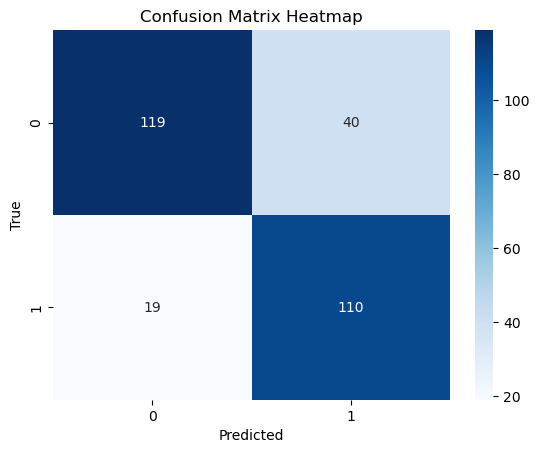

In [44]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test_binary, late_fusion_predictions), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

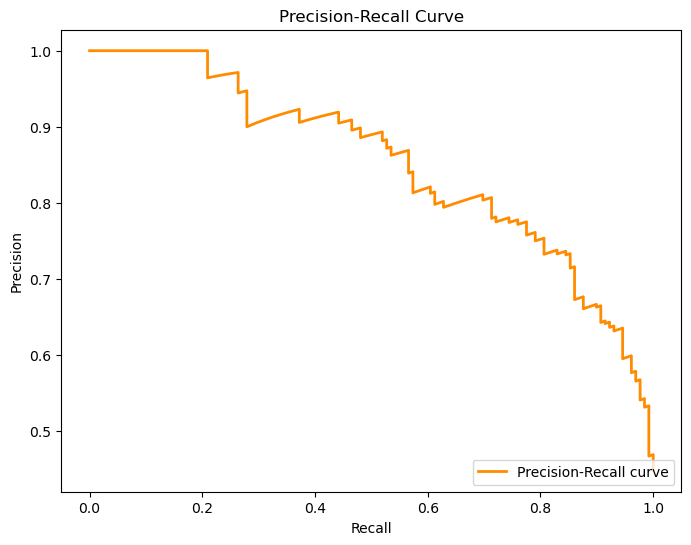

In [45]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test_binary, late_fusion_predictions_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

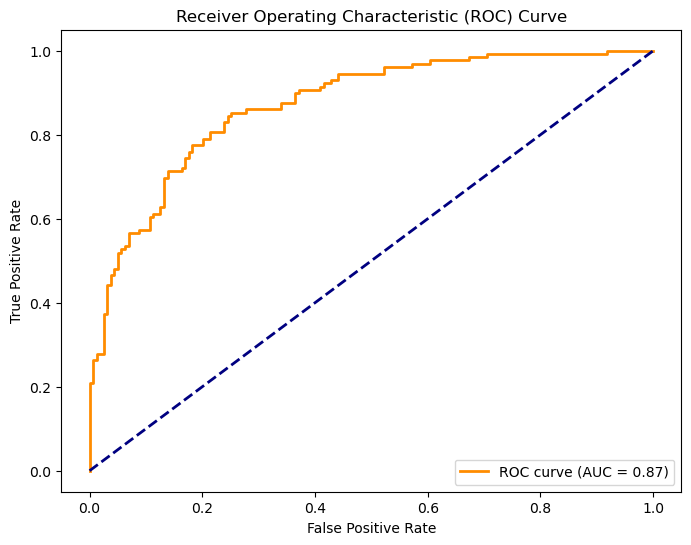

In [46]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test_binary, late_fusion_predictions_proba)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [47]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test_binary, late_fusion_predictions)
print("Matthews Correlation Coefficient:", mcc)

Matthews Correlation Coefficient: 0.5983902195685744


In [48]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test_binary, late_fusion_predictions_proba)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.8713373311881428


In [49]:
from sklearn.metrics import auc
auc_pr = auc(recall, precision)
print("AUC-PR:", auc_pr)

AUC-PR: 0.8512129311085325


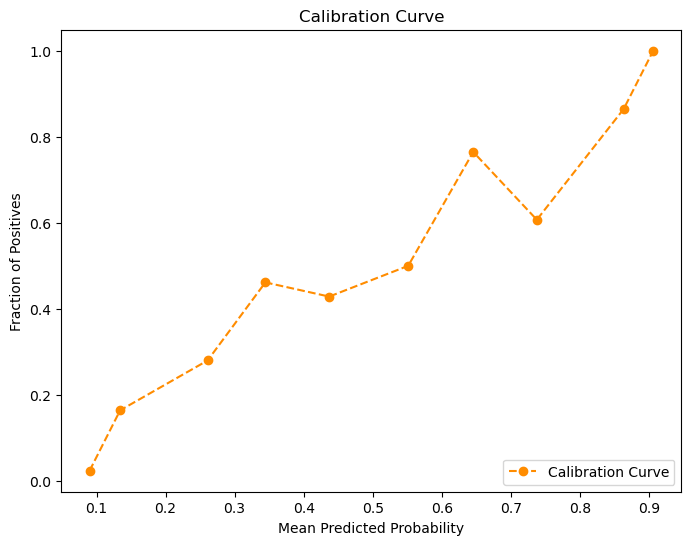

In [50]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test_binary, late_fusion_predictions_proba, n_bins=10, strategy='uniform')

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='--', color='darkorange', label='Calibration Curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc="lower right")
plt.show()

In [51]:
from sklearn.metrics import log_loss
logloss = log_loss(y_test_binary, late_fusion_predictions_proba)
print("Log-Loss:", logloss)

Log-Loss: 0.45333213186256166


In [52]:
from sklearn.metrics import brier_score_loss
brier_score = brier_score_loss(y_test_binary, late_fusion_predictions_proba)
print("Brier Score:", brier_score)

Brier Score: 0.14616556258908936
